# Final Experiments
by: Cristobal Estrada Salinas

## Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

## Data Loading

In [11]:
data = pd.read_csv('datasets/FullDay_revised.csv')
data['weekday'] = pd.to_datetime(data['date']).dt.day_name()
data = data.rename(columns={'patient_type': 'type'})

data

,patient_id,type,date,total_act,mean_act,std_act,max_act,min_act,median_act,inactivity_perc,total_count,non_zero_count,patient_group,weekday
0,1,1,2003-03-18,209876,388.659259,523.290473,2341,3,131.0,19.629630,540,434,Control,Tuesday
1,1,1,2003-03-19,267218,185.568056,346.555786,3097,3,37.5,38.680556,1440,883,Control,Wednesday
2,1,1,2003-03-20,325413,225.981250,384.378661,2651,3,53.0,35.833333,1440,924,Control,Thursday
3,1,1,2003-03-21,244315,169.663194,304.317895,2066,3,18.0,45.625000,1440,783,Control,Friday
4,1,1,2003-03-22,264515,183.690972,277.006551,2415,3,106.0,36.111111,1440,920,Control,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,32,1,2003-03-27,349608,242.783333,397.951326,4009,2,57.0,32.777778,1440,968,Control,Thursday
689,32,1,2003-03-28,281657,195.595139,279.909048,1849,2,72.0,27.152778,1440,1049,Control,Friday
690,32,1,2003-03-29,249872,173.522222,298.028753,2521,2,31.0,39.027778,1440,878,Control,Saturday
691,32,1,2003-03-30,254956,184.750725,350.507266,3654,2,16.0,42.391304,1380,795,Control,Sunday


## Glossary

- `patient_id`: ID del paciente.

- `type`: Tipo de paciente. 0 = condition, 1 = control.

- `date`: Fecha de registro.

- `total_act`: Suma total de la act. por segmento.

- `mean_act`: Promedio de actividad total por segmento.

- `std_act`: Desviación estándar de la act. total por segmento.

- `max_act`: Registro máximo de actividad por segmento.

- `min_act`: Registro mínimo de actividad (mayor a cero) total por segmento.

- `median_act`: Mediana de la actividad por segmento.

- `inactivity_perc`: Porcentaje de inactividad por segmento.

- `total_count`: Número total de registros por segmento.

- `non_zero_count`: Número de registros por segmento diferentes a cero.

- `patient_group`: Grupo de pacientes al que pertenece el registro.

- `weekday`: Día de la semana correspondiente al registro.

## Cross-Validation

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def manual_cv(X, y, model, n_splits=10, random_state=42):
    np.random.seed(random_state)
    
    X = np.array(X)
    y = np.array(y)
    
    class_indices = {}
    unique_classes = np.unique(y)
    for cls in unique_classes:
        class_indices[cls] = np.where(y == cls)[0]
    
    for cls in unique_classes:
        np.random.shuffle(class_indices[cls])
    
    folds = []
    for i in range(n_splits):
        fold = []
        for cls in unique_classes:
            n_samples = len(class_indices[cls])
            start_idx = int(i * n_samples / n_splits)
            end_idx = int((i + 1) * n_samples / n_splits)
            
            if i == n_splits - 1:
                fold.extend(class_indices[cls][start_idx:])
            else:
                fold.extend(class_indices[cls][start_idx:end_idx])
        folds.append(np.array(fold))
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    y_true_all = []
    y_pred_all = []
    
    for i in range(n_splits):
        test_indices = folds[i]
        train_indices = np.concatenate([folds[j] for j in range(n_splits) if j != i])
        
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
    
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(np.array(y_true_all), np.array(y_pred_all))
    
    return {
        "accuracy": {
            "mean": np.mean(accuracy_scores),
            "std": np.std(accuracy_scores)
        },
        "precision": {
            "mean": np.mean(precision_scores),
            "std": np.std(precision_scores)
        },
        "recall": {
            "mean": np.mean(recall_scores),
            "std": np.std(recall_scores)
        },
        "f1": {
            "mean": np.mean(f1_scores),
            "std": np.std(f1_scores)
        },
        "confusion_matrix": conf_matrix,
        "y_true": np.array(y_true_all),
        "y_pred": np.array(y_pred_all)
    }

## Models definition

In [13]:
svm = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='linear', C=1, random_state=42, probability=True))
])

rForest = Pipeline([
    ('scaler', StandardScaler()),
    ('new_rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('new_knn', KNeighborsClassifier(n_neighbors=5))
])

gradBoost = Pipeline([
    ('scaler', StandardScaler()),
    ('new_gb', GradientBoostingClassifier(random_state=42))
])


logReg = Pipeline([
    ('scaler', StandardScaler()),
    ('new_logreg', LogisticRegression(random_state=42, max_iter=1000))
])

models = {
    'SVM': svm,
    'Random Forest': rForest,
    'KNN': knn,
    'Gradient Boosting': gradBoost,
    'Logistic Regression': logReg
}

## All-features Two Segments Models

### Double Segmented Dataset

In [69]:
df = pd.read_csv('datasets/DoubleSegmented_revised.csv')
df['weekday'] = pd.to_datetime(df['date_']).dt.day_name()
df = df.rename(columns={'patient_type_': 'type'})

df

,patient_id_,type,date_,patient_group_,inactivity_perc_1,inactivity_perc_2,max_act_1,max_act_2,mean_act_1,mean_act_2,...,min_act_2,non_zero_count_1,non_zero_count_2,std_act_1,std_act_2,total_activity_1,total_activity_2,total_count_1,total_count_2,weekday
0,1,0,2003-05-07,Condition,NaN,20.416667,NaN,2284.0,NaN,174.144444,...,3.0,NaN,573.0,NaN,240.053885,NaN,125384.0,NaN,720.0,Wednesday
1,1,0,2003-05-08,Condition,61.944444,19.861111,1954.0,1725.0,88.820833,223.673611,...,3.0,274.0,577.0,192.920393,242.346911,63951.0,161045.0,720.0,720.0,Thursday
2,1,0,2003-05-09,Condition,64.583333,27.777778,1474.0,1672.0,82.833333,165.437500,...,3.0,255.0,520.0,201.803523,212.524554,59640.0,119115.0,720.0,720.0,Friday
3,1,0,2003-05-10,Condition,60.416667,14.444444,1570.0,2146.0,82.918056,187.005556,...,3.0,285.0,616.0,200.733419,247.054284,59701.0,134644.0,720.0,720.0,Saturday
4,1,0,2003-05-11,Condition,65.694444,18.333333,1111.0,2080.0,69.915278,128.963889,...,3.0,247.0,588.0,153.188140,194.936668,50339.0,92854.0,720.0,720.0,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,32,1,2003-03-27,Control,50.972222,14.583333,1908.0,4009.0,115.156944,370.409722,...,2.0,353.0,615.0,245.781944,473.201554,82913.0,266695.0,720.0,720.0,Thursday
689,32,1,2003-03-28,Control,12.361111,41.944444,1849.0,1196.0,245.655556,145.534722,...,2.0,631.0,418.0,314.475939,229.984656,176872.0,104785.0,720.0,720.0,Friday
690,32,1,2003-03-29,Control,69.166667,8.888889,1123.0,2521.0,35.005556,312.038889,...,2.0,222.0,656.0,110.516287,356.545727,25204.0,224668.0,720.0,720.0,Saturday
691,32,1,2003-03-30,Control,55.151515,30.694444,3654.0,1684.0,185.787879,183.800000,...,2.0,296.0,499.0,405.582760,291.302736,122620.0,132336.0,660.0,720.0,Sunday


### Data Splitting

In [70]:
features = ["total_activity_1", "total_activity_2", 'mean_act_1', 
            'mean_act_2', 'std_act_1', 'std_act_2', 
            'max_act_1', 'max_act_2', 'min_act_1', 'min_act_2', 
            'median_act_1', 'median_act_2',
            'inactivity_perc_1', 'inactivity_perc_2']
X = df[features].dropna()
y = df.loc[X.index, 'type']

In [71]:
X

,total_activity_1,total_activity_2,mean_act_1,mean_act_2,std_act_1,std_act_2,max_act_1,max_act_2,min_act_1,min_act_2,median_act_1,median_act_2,inactivity_perc_1,inactivity_perc_2
1,63951.0,161045.0,88.820833,223.673611,192.920393,242.346911,1954.0,1725.0,3.0,3.0,0.0,166.0,61.944444,19.861111
2,59640.0,119115.0,82.833333,165.437500,201.803523,212.524554,1474.0,1672.0,3.0,3.0,0.0,83.5,64.583333,27.777778
3,59701.0,134644.0,82.918056,187.005556,200.733419,247.054284,1570.0,2146.0,3.0,3.0,0.0,98.0,60.416667,14.444444
4,50339.0,92854.0,69.915278,128.963889,153.188140,194.936668,1111.0,2080.0,3.0,3.0,0.0,49.0,65.694444,18.333333
5,54582.0,401717.0,75.808333,557.940278,222.176644,571.831713,1894.0,3526.0,3.0,3.0,0.0,439.0,68.472222,10.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,82913.0,266695.0,115.156944,370.409722,245.781944,473.201554,1908.0,4009.0,2.0,2.0,0.0,193.0,50.972222,14.583333
689,176872.0,104785.0,245.655556,145.534722,314.475939,229.984656,1849.0,1196.0,2.0,2.0,116.0,15.5,12.361111,41.944444
690,25204.0,224668.0,35.005556,312.038889,110.516287,356.545727,1123.0,2521.0,2.0,2.0,0.0,174.0,69.166667,8.888889
691,122620.0,132336.0,185.787879,183.800000,405.582760,291.302736,3654.0,1684.0,2.0,2.0,0.0,46.0,55.151515,30.694444


### Evaluation

In [16]:
confusion_matrices = {}
metrics_results = {}

for name, model in models.items():
    print(f'Evaluating {name}...')
    cv_results = manual_cv(X, y, model, n_splits=10, random_state=42)
    
    confusion_matrices[name] = cv_results['confusion_matrix']
    
    metrics_results[name] = {
        "Mean F1 Score": cv_results["f1"]["mean"],
        "Std F1 Score": cv_results["f1"]["std"],
        "Mean Accuracy": cv_results["accuracy"]["mean"],
        "Std Accuracy": cv_results["accuracy"]["std"],
        "Mean Precision": cv_results["precision"]["mean"],
        "Std Precision": cv_results["precision"]["std"],
        "Mean Recall": cv_results["recall"]["mean"],
        "Std Recall": cv_results["recall"]["std"]
   }

Evaluating SVM...
Evaluating Random Forest...
Evaluating KNN...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linea

In [17]:
df_MR = pd.DataFrame.from_dict(metrics_results, orient='columns')
df_MR = df_MR.T
df_MR_sorted = df_MR.sort_values(by='Mean F1 Score', ascending=False)
print("Cross-Validation Metrics:")
df_MR_sorted

Cross-Validation Metrics:


,Mean F1 Score,Std F1 Score,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall
Random Forest,0.813353,0.033269,0.771258,0.042287,0.776501,0.038265,0.854679,0.035895
KNN,0.811704,0.038338,0.771279,0.051552,0.786802,0.063193,0.841795,0.039438
Gradient Boosting,0.804750,0.037171,0.766823,0.047976,0.790774,0.057490,0.821538,0.035588
SVM,0.781252,0.032478,0.719192,0.039391,0.714789,0.028710,0.862244,0.045978
Logistic Regression,0.766331,0.035370,0.710323,0.038200,0.720847,0.022547,0.818846,0.055072


### Results

In [18]:
cm_metrics = {}

for name, cm in confusion_matrices.items():
    tn, fp = cm[0,0], cm[0,1]
    fn, tp = cm[1,0], cm[1,1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    cm_metrics[name] = {
        "F1 Score": round(f1, 4),
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4)
    }

In [19]:
cm_metrics_df = pd.DataFrame.from_dict(cm_metrics, orient='index')

In [20]:
for name, cm in confusion_matrices.items():
    class_0_samples = cm[0, 0] + cm[0, 1]
    class_1_samples = cm[1, 0] + cm[1, 1]
    total_samples = class_0_samples + class_1_samples
    
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    recall_0 = cm[0, 0] / class_0_samples if class_0_samples > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    
    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall_1 = cm[1, 1] / class_1_samples if class_1_samples > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    weighted_f1 = (class_0_samples/total_samples * f1_0) + (class_1_samples/total_samples * f1_1)
    cm_metrics_df.at[name, "Weighted F1"] = round(weighted_f1, 4)
    
metrics_sorted = cm_metrics_df.sort_values(by='F1 Score', ascending=False)
print("\nConfusion Matrix Metrics:")
metrics_sorted


Confusion Matrix Metrics:


,F1 Score,Accuracy,Precision,Recall,Weighted F1
Random Forest,0.8131,0.7712,0.7755,0.8546,0.7680
KNN,0.8108,0.7712,0.7820,0.8418,0.7689
Gradient Boosting,0.8040,0.7667,0.7873,0.8214,0.7656
SVM,0.7815,0.7192,0.7146,0.8622,0.7087
Logistic Regression,0.7670,0.7103,0.7213,0.8189,0.7043


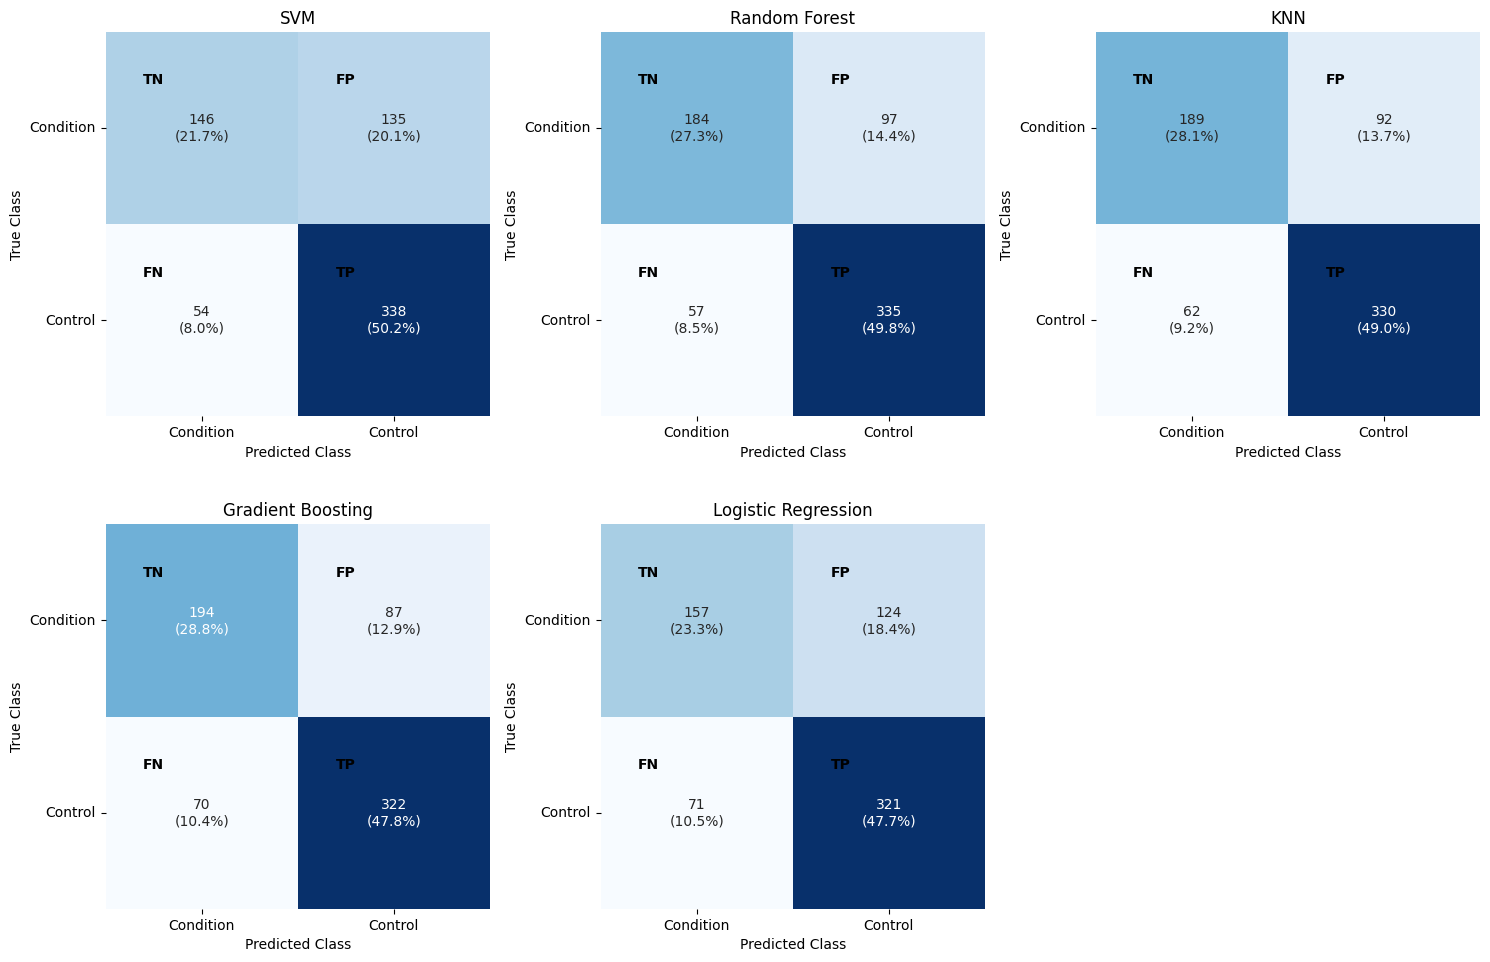

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
cmap = plt.cm.Blues

for i, (name, cm) in enumerate(confusion_matrices.items()):
    if i < len(axes):
        # calculate percentages
        cm_sum = np.sum(cm)
        cm_percentages = cm / cm_sum * 100
        
        annot = np.empty_like(cm, dtype=object)
        for j in range(cm.shape[0]):
            for k in range(cm.shape[1]):
                annot[j, k] = f"{cm[j, k]}\n({cm_percentages[j, k]:.1f}%)"

        sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, ax=axes[i],
                cbar=False, square=True)
       
        title = f"{name}"
        axes[i].set_title(title)
        
        # labels for true and predicted classes
        axes[i].set_xlabel('Predicted Class')
        axes[i].set_ylabel('True Class')
        
        axes[i].set_xticklabels(['Condition', 'Control'])
        axes[i].set_yticklabels(['Condition', 'Control'], rotation=0)
        
        # set ticks
        axes[i].text(0.25, 0.25, 'TN', color='black', ha='center', va='center', fontweight='bold')
        axes[i].text(1.25, 0.25, 'FP', color='black', ha='center', va='center', fontweight='bold')
        axes[i].text(0.25, 1.25, 'FN', color='black', ha='center', va='center', fontweight='bold')
        axes[i].text(1.25, 1.25, 'TP', color='black', ha='center', va='center', fontweight='bold')

if len(models) < len(axes):
    for i in range(len(models), len(axes)):
        fig.delaxes(axes[i])
        
plt.tight_layout()
plt.show()

## Twice Segmented Models

In [72]:
clean_df = df.dropna(subset=features)

In [73]:
segment1_features = ["total_activity_1", 'mean_act_1', 'std_act_1', 'max_act_1', 'min_act_1', 'median_act_1', 'inactivity_perc_1']
segment2_features = ["total_activity_2", 'mean_act_2', 'std_act_2', 'max_act_2', 'min_act_2', 'median_act_2', 'inactivity_perc_2']

In [74]:
X_segment1 = clean_df[segment1_features].values
X_segment2 = clean_df[segment2_features].values

y = clean_df["type"].values

In [75]:
X_segment1

array([[6.39510000e+04, 8.88208333e+01, 1.92920393e+02, ...,
        3.00000000e+00, 0.00000000e+00, 6.19444444e+01],
       [5.96400000e+04, 8.28333333e+01, 2.01803523e+02, ...,
        3.00000000e+00, 0.00000000e+00, 6.45833333e+01],
       [5.97010000e+04, 8.29180556e+01, 2.00733419e+02, ...,
        3.00000000e+00, 0.00000000e+00, 6.04166667e+01],
       ...,
       [2.52040000e+04, 3.50055556e+01, 1.10516287e+02, ...,
        2.00000000e+00, 0.00000000e+00, 6.91666667e+01],
       [1.22620000e+05, 1.85787879e+02, 4.05582760e+02, ...,
        2.00000000e+00, 0.00000000e+00, 5.51515152e+01],
       [9.81230000e+04, 1.36281944e+02, 3.13783284e+02, ...,
        2.00000000e+00, 0.00000000e+00, 5.76388889e+01]], shape=(673, 7))

In [76]:
X_segment2

array([[1.61045000e+05, 2.23673611e+02, 2.42346911e+02, ...,
        3.00000000e+00, 1.66000000e+02, 1.98611111e+01],
       [1.19115000e+05, 1.65437500e+02, 2.12524554e+02, ...,
        3.00000000e+00, 8.35000000e+01, 2.77777778e+01],
       [1.34644000e+05, 1.87005556e+02, 2.47054284e+02, ...,
        3.00000000e+00, 9.80000000e+01, 1.44444444e+01],
       ...,
       [2.24668000e+05, 3.12038889e+02, 3.56545727e+02, ...,
        2.00000000e+00, 1.74000000e+02, 8.88888889e+00],
       [1.32336000e+05, 1.83800000e+02, 2.91302736e+02, ...,
        2.00000000e+00, 4.60000000e+01, 3.06944444e+01],
       [1.93909000e+05, 2.69318056e+02, 2.92360320e+02, ...,
        2.00000000e+00, 1.65500000e+02, 8.47222222e+00]], shape=(673, 7))

### Segment 1

In [25]:
print("\n=== SEGMENT 1 RESULTS ===")
segment1_results = {}
segment1_confusion_matrices = {}

for name, model in models.items():
    print(f"Evaluating {name} on Segment 1...")
    cv_results = manual_cv(X_segment1, y, model, n_splits=10)
    
    segment1_confusion_matrices[name] = cv_results["confusion_matrix"]
    
    segment1_results[name] = {
        "Mean F1 Score": cv_results["f1"]["mean"],
        "Std F1 Score": cv_results["f1"]["std"],
        "Mean Accuracy": cv_results["accuracy"]["mean"],
        "Std Accuracy": cv_results["accuracy"]["std"],
        "Mean Precision": cv_results["precision"]["mean"],
        "Std Precision": cv_results["precision"]["std"],
        "Mean Recall": cv_results["recall"]["mean"],
        "Std Recall": cv_results["recall"]["std"]
    }


=== SEGMENT 1 RESULTS ===
Evaluating SVM on Segment 1...
Evaluating Random Forest on Segment 1...
Evaluating KNN on Segment 1...
Evaluating Gradient Boosting on Segment 1...
Evaluating Logistic Regression on Segment 1...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarnin

In [26]:
segment1_df = pd.DataFrame.from_dict(segment1_results, orient='index')
segment1_df_sorted = segment1_df.sort_values(by='Mean F1 Score', ascending=False)
print("\nSegment 1 Cross-Validation Results:")
segment1_df_sorted


Segment 1 Cross-Validation Results:


,Mean F1 Score,Std F1 Score,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall
Random Forest,0.817197,0.049517,0.779780,0.061312,0.794553,0.058326,0.844103,0.059231
Gradient Boosting,0.789222,0.029274,0.750449,0.041518,0.783434,0.056955,0.798718,0.035251
SVM,0.756753,0.043651,0.705629,0.050648,0.729920,0.044406,0.788141,0.062140
KNN,0.756403,0.031549,0.714716,0.039215,0.756511,0.050070,0.760192,0.047537
Logistic Regression,0.754410,0.042639,0.698275,0.049502,0.718337,0.045660,0.798397,0.070329


In [27]:
segment1_cm_metrics = {}
for name, cm in segment1_confusion_matrices.items():
    tn, fp = cm[0, 0], cm[0, 1]
    fn, tp = cm[1, 0], cm[1, 1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_0_samples = cm[0, 0] + cm[0, 1]
    class_1_samples = cm[1, 0] + cm[1, 1]
    total_samples = class_0_samples + class_1_samples
    
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    recall_0 = cm[0, 0] / class_0_samples if class_0_samples > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    
    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall_1 = cm[1, 1] / class_1_samples if class_1_samples > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    weighted_f1 = (class_0_samples/total_samples * f1_0) + (class_1_samples/total_samples * f1_1)
    
    segment1_cm_metrics[name] = {
        "F1 Score": round(f1, 4),
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "Weighted F1": round(weighted_f1, 4)
    }

In [28]:
segment1_cm_df = pd.DataFrame.from_dict(segment1_cm_metrics, orient='index')
segment1_cm_df_sorted = segment1_cm_df.sort_values(by='F1 Score', ascending=False)
print("\nSegment 1 Confusion Matrix Metrics:")
segment1_cm_df_sorted



Segment 1 Confusion Matrix Metrics:


,F1 Score,Accuracy,Precision,Recall,Weighted F1
Random Forest,0.8173,0.7801,0.7919,0.8444,0.7783
Gradient Boosting,0.7884,0.7504,0.7786,0.7985,0.7497
SVM,0.7574,0.7058,0.7288,0.7883,0.7027
KNN,0.7563,0.7147,0.7525,0.7602,0.7144
Logistic Regression,0.7551,0.6984,0.7162,0.7985,0.6934


### Segment 2

In [29]:
print("\n=== SEGMENT 2 RESULTS ===")
segment2_results = {}
segment2_confusion_matrices = {}

for name, model in models.items():
    print(f"Evaluating {name} on Segment 2...")
    cv_results = manual_cv(X_segment2, y, model, n_splits=10)
    
    segment2_confusion_matrices[name] = cv_results["confusion_matrix"]
    
    segment2_results[name] = {
        "Mean F1 Score": cv_results["f1"]["mean"],
        "Std F1 Score": cv_results["f1"]["std"],
        "Mean Accuracy": cv_results["accuracy"]["mean"],
        "Std Accuracy": cv_results["accuracy"]["std"],
        "Mean Precision": cv_results["precision"]["mean"],
        "Std Precision": cv_results["precision"]["std"],
        "Mean Recall": cv_results["recall"]["mean"],
        "Std Recall": cv_results["recall"]["std"]
    }


=== SEGMENT 2 RESULTS ===
Evaluating SVM on Segment 2...
Evaluating Random Forest on Segment 2...
Evaluating KNN on Segment 2...
Evaluating Gradient Boosting on Segment 2...
Evaluating Logistic Regression on Segment 2...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarnin

In [30]:
segment2_df = pd.DataFrame.from_dict(segment2_results, orient='index')
segment2_df_sorted = segment2_df.sort_values(by='Mean F1 Score', ascending=False)
print("\nSegment 2 Cross-Validation Results:")
segment2_df_sorted


Segment 2 Cross-Validation Results:


,Mean F1 Score,Std F1 Score,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall
SVM,0.796714,0.032285,0.728018,0.038731,0.704327,0.022315,0.918333,0.057088
Logistic Regression,0.787096,0.033659,0.728061,0.036032,0.722479,0.026842,0.867244,0.063698
Random Forest,0.769587,0.046086,0.714715,0.050200,0.723265,0.027372,0.823846,0.073190
Gradient Boosting,0.766703,0.041957,0.711664,0.049867,0.724887,0.038391,0.816154,0.063826
KNN,0.766252,0.051425,0.716185,0.055526,0.732882,0.035829,0.806026,0.083668


In [31]:
segment2_cm_metrics = {}
for name, cm in segment2_confusion_matrices.items():
    tn, fp = cm[0, 0], cm[0, 1]
    fn, tp = cm[1, 0], cm[1, 1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_0_samples = cm[0, 0] + cm[0, 1]
    class_1_samples = cm[1, 0] + cm[1, 1]
    total_samples = class_0_samples + class_1_samples
    
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    recall_0 = cm[0, 0] / class_0_samples if class_0_samples > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    
    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall_1 = cm[1, 1] / class_1_samples if class_1_samples > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    weighted_f1 = (class_0_samples/total_samples * f1_0) + (class_1_samples/total_samples * f1_1)
    
    segment2_cm_metrics[name] = {
        "F1 Score": round(f1, 4),
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "Weighted F1": round(weighted_f1, 4)
    }

In [32]:
segment2_cm_df = pd.DataFrame.from_dict(segment2_cm_metrics, orient='index')
segment2_cm_df_sorted = segment2_cm_df.sort_values(by='F1 Score', ascending=False)
print("\nSegment 2 Confusion Matrix Metrics:")
segment2_cm_df_sorted


Segment 2 Confusion Matrix Metrics:


,F1 Score,Accuracy,Precision,Recall,Weighted F1
SVM,0.7973,0.7281,0.7045,0.9184,0.7095
Logistic Regression,0.7879,0.7281,0.7219,0.8673,0.7183
Random Forest,0.7709,0.7147,0.7242,0.8240,0.7087
KNN,0.7679,0.7162,0.7332,0.8061,0.7123
Gradient Boosting,0.7674,0.7117,0.7240,0.8163,0.7063


### Best Models Confusion Matrices

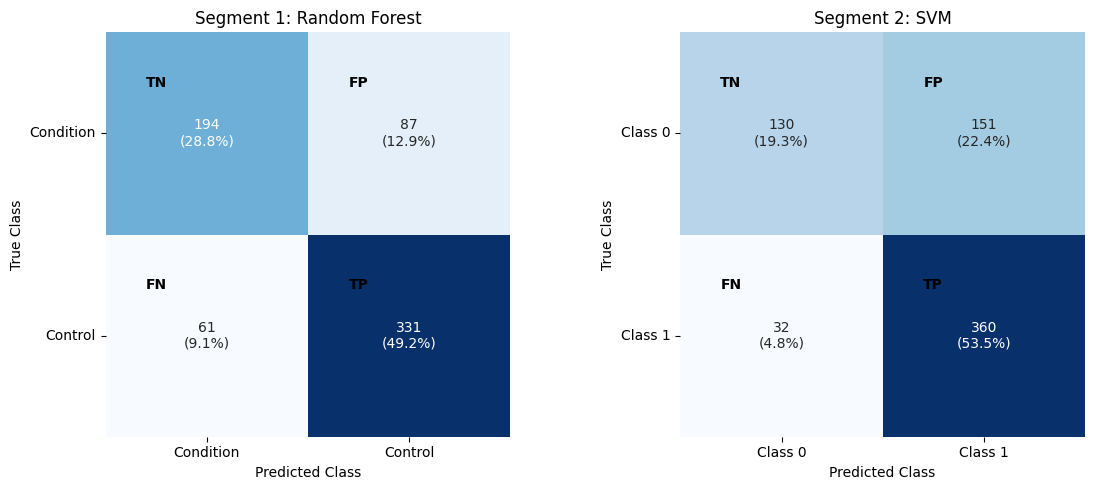

In [33]:
best_model_seg1 = segment1_df_sorted.index[0]
best_model_seg2 = segment2_df_sorted.index[0]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cmap = plt.cm.Blues

# segment 1
cm = segment1_confusion_matrices[best_model_seg1]
# calculate percentages
cm_sum = np.sum(cm)
cm_percentages = cm / cm_sum * 100

annot = np.empty_like(cm, dtype=object)
for j in range(cm.shape[0]):
    for k in range(cm.shape[1]):
        annot[j, k] = f"{cm[j, k]}\n({cm_percentages[j, k]:.1f}%)"
        
sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, ax=axes[0],
          cbar=False, square=True)
axes[0].set_title(f"Segment 1: {best_model_seg1}")

# labels true and predicted classes
axes[0].set_xlabel('Predicted Class')
axes[0].set_ylabel('True Class')

axes[0].set_xticklabels(['Condition', 'Control'])
axes[0].set_yticklabels(['Condition', 'Control'], rotation=0)

# set ticks
axes[0].text(0.25, 0.25, 'TN', color='black', ha='center', va='center', fontweight='bold')
axes[0].text(1.25, 0.25, 'FP', color='black', ha='center', va='center', fontweight='bold')
axes[0].text(0.25, 1.25, 'FN', color='black', ha='center', va='center', fontweight='bold')
axes[0].text(1.25, 1.25, 'TP', color='black', ha='center', va='center', fontweight='bold')

# segment 2
cm = segment2_confusion_matrices[best_model_seg2]
# calculate percentages
cm_sum = np.sum(cm)
cm_percentages = cm / cm_sum * 100

annot = np.empty_like(cm, dtype=object)
for j in range(cm.shape[0]):
    for k in range(cm.shape[1]):
        annot[j, k] = f"{cm[j, k]}\n({cm_percentages[j, k]:.1f}%)"
        
sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, ax=axes[1],
          cbar=False, square=True)
axes[1].set_title(f"Segment 2: {best_model_seg2}")

# labels true and predicted classes
axes[1].set_xlabel('Predicted Class')
axes[1].set_ylabel('True Class')

axes[1].set_xticklabels(['Class 0', 'Class 1'])
axes[1].set_yticklabels(['Class 0', 'Class 1'], rotation=0)

# ticks
axes[1].text(0.25, 0.25, 'TN', color='black', ha='center', va='center', fontweight='bold')
axes[1].text(1.25, 0.25, 'FP', color='black', ha='center', va='center', fontweight='bold')
axes[1].text(0.25, 1.25, 'FN', color='black', ha='center', va='center', fontweight='bold')
axes[1].text(1.25, 1.25, 'TP', color='black', ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### Comparison

In [34]:
two_segment_comparison = pd.DataFrame({
    'Segment': ['Segment 1', 'Segment 2'],
    'Best Model': [
        segment1_df_sorted.index[0],
        segment2_df_sorted.index[0]
    ],
    'Best F1 Score': [
        segment1_df_sorted.iloc[0]['Mean F1 Score'],
        segment2_df_sorted.iloc[0]['Mean F1 Score']
    ]
})

print("\n=== COMPARISON OF TWO SEGMENTS ===")
print(two_segment_comparison)


=== COMPARISON OF TWO SEGMENTS ===
     Segment     Best Model  Best F1 Score
0  Segment 1  Random Forest       0.817197
1  Segment 2            SVM       0.796714


## Whole Day Models (No Segmentation)

In [35]:
data

,patient_id,type,date,total_act,mean_act,std_act,max_act,min_act,median_act,inactivity_perc,total_count,non_zero_count,patient_group,weekday
0,1,1,2003-03-18,209876,388.659259,523.290473,2341,3,131.0,19.629630,540,434,Control,Tuesday
1,1,1,2003-03-19,267218,185.568056,346.555786,3097,3,37.5,38.680556,1440,883,Control,Wednesday
2,1,1,2003-03-20,325413,225.981250,384.378661,2651,3,53.0,35.833333,1440,924,Control,Thursday
3,1,1,2003-03-21,244315,169.663194,304.317895,2066,3,18.0,45.625000,1440,783,Control,Friday
4,1,1,2003-03-22,264515,183.690972,277.006551,2415,3,106.0,36.111111,1440,920,Control,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,32,1,2003-03-27,349608,242.783333,397.951326,4009,2,57.0,32.777778,1440,968,Control,Thursday
689,32,1,2003-03-28,281657,195.595139,279.909048,1849,2,72.0,27.152778,1440,1049,Control,Friday
690,32,1,2003-03-29,249872,173.522222,298.028753,2521,2,31.0,39.027778,1440,878,Control,Saturday
691,32,1,2003-03-30,254956,184.750725,350.507266,3654,2,16.0,42.391304,1380,795,Control,Sunday


In [36]:
new_features = ['total_act', 'mean_act', 'std_act', 'max_act', 'min_act', 'median_act', 'inactivity_perc']
X_hat = data[new_features]
y_hat = data.loc[X_hat.index, 'type']

In [37]:
X_hat

,total_act,mean_act,std_act,max_act,min_act,median_act,inactivity_perc
0,209876,388.659259,523.290473,2341,3,131.0,19.629630
1,267218,185.568056,346.555786,3097,3,37.5,38.680556
2,325413,225.981250,384.378661,2651,3,53.0,35.833333
3,244315,169.663194,304.317895,2066,3,18.0,45.625000
4,264515,183.690972,277.006551,2415,3,106.0,36.111111
...,...,...,...,...,...,...,...
688,349608,242.783333,397.951326,4009,2,57.0,32.777778
689,281657,195.595139,279.909048,1849,2,72.0,27.152778
690,249872,173.522222,298.028753,2521,2,31.0,39.027778
691,254956,184.750725,350.507266,3654,2,16.0,42.391304


In [38]:
confMatr = {}
manMetr = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    cv_results = manual_cv(X_hat, y_hat, model, n_splits=10, random_state=42)
    
    confMatr[name] = cv_results["confusion_matrix"]
    
    manMetr[name] = {
        "Mean F1 Score": cv_results["f1"]["mean"],
        "Std F1 Score": cv_results["f1"]["std"],
        "Mean Accuracy": cv_results["accuracy"]["mean"],
        "Std Accuracy": cv_results["accuracy"]["std"],
        "Mean Precision": cv_results["precision"]["mean"],
        "Std Precision": cv_results["precision"]["std"],
        "Mean Recall": cv_results["recall"]["mean"],
        "Std Recall": cv_results["recall"]["std"]
   }

Evaluating SVM...
Evaluating Random Forest...
Evaluating KNN...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarnin

In [39]:
manual_metrics = pd.DataFrame.from_dict(manMetr, orient='columns')
manual_metrics = manual_metrics.T
manual_metrics_sorted = manual_metrics.sort_values(by='Mean F1 Score', ascending=False)
print('Cross-Validation Metrics')
manual_metrics

Cross-Validation Metrics


,Mean F1 Score,Std F1 Score,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall
SVM,0.804166,0.030561,0.758954,0.031297,0.758852,0.023314,0.858110,0.063047
Random Forest,0.793193,0.029401,0.746034,0.039401,0.755397,0.047046,0.838232,0.043272
KNN,0.791596,0.024549,0.748851,0.033570,0.765619,0.036882,0.820915,0.028950
Gradient Boosting,0.807134,0.034794,0.766242,0.037878,0.773568,0.036157,0.848171,0.069853
Logistic Regression,0.793003,0.034812,0.750341,0.033008,0.760985,0.019423,0.830793,0.068569


In [40]:
hat_metrics_from_cm = {}

for name, cm in confMatr.items():
    tn, fp = cm[0, 0], cm[0, 1]
    fn, tp = cm[1, 0], cm[1, 1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    hat_metrics_from_cm[name] = {
        "F1 Score": round(f1, 4),
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4)
    }

In [41]:
hat_cm_metrics_df = pd.DataFrame.from_dict(hat_metrics_from_cm, orient='index')

In [42]:
for name, cm in confMatr.items():
    class_0_samples = cm[0, 0] + cm[0, 1]
    class_1_samples = cm[1, 0] + cm[1, 1]
    total_samples = class_0_samples + class_1_samples
    
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    recall_0 = cm[0, 0] / class_0_samples if class_0_samples > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    
    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall_1 = cm[1, 1] / class_1_samples if class_1_samples > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    weighted_f1 = (class_0_samples/total_samples * f1_0) + (class_1_samples/total_samples * f1_1)
    hat_cm_metrics_df.at[name, "Weighted F1"] = round(weighted_f1, 4)
    

hat_metrics_df_sorted = hat_cm_metrics_df.sort_values(by='F1 Score', ascending=False)
print("\nConfusion Matrix Metrics:")
hat_metrics_df_sorted


Confusion Matrix Metrics:


,F1 Score,Accuracy,Precision,Recall,Weighted F1
Gradient Boosting,0.8081,0.7662,0.7715,0.8483,0.7631
SVM,0.8051,0.7590,0.7582,0.8582,0.7544
Logistic Regression,0.7943,0.7504,0.7608,0.8308,0.7474
Random Forest,0.7929,0.7460,0.7522,0.8383,0.7420
KNN,0.7914,0.7489,0.7639,0.8209,0.7466


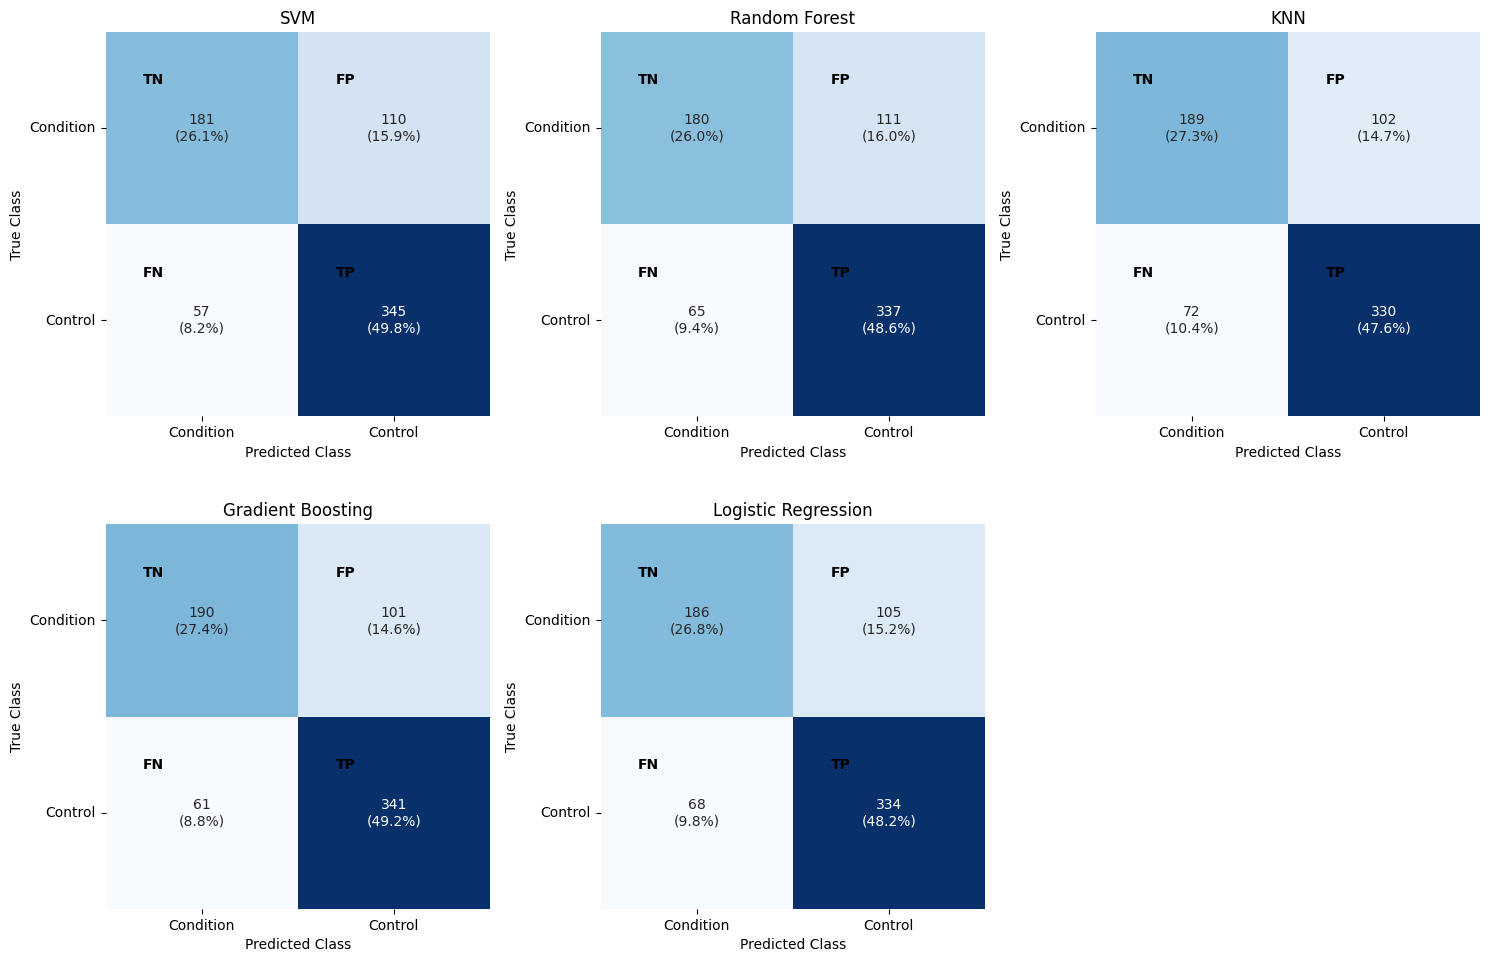

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
cmap = plt.cm.Blues
for i, (name, cm) in enumerate(confMatr.items()):
    if i < len(axes):
        # calculate percentages
        cm_sum = np.sum(cm)
        cm_percentages = cm / cm_sum * 100

        annot = np.empty_like(cm, dtype=object)
        for j in range(cm.shape[0]):
            for k in range(cm.shape[1]):
                annot[j, k] = f"{cm[j, k]}\n({cm_percentages[j, k]:.1f}%)"
        sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, ax=axes[i],
                cbar=False, square=True)

        title = f"{name}"
        axes[i].set_title(title)

        # labels for true and predicted classes
        axes[i].set_xlabel('Predicted Class')
        axes[i].set_ylabel('True Class')

        axes[i].set_xticklabels(['Condition', 'Control'])
        axes[i].set_yticklabels(['Condition', 'Control'], rotation=0)

        # set ticks
        axes[i].text(0.25, 0.25, 'TN', color='black', ha='center', va='center', fontweight='bold')
        axes[i].text(1.25, 0.25, 'FP', color='black', ha='center', va='center', fontweight='bold')
        axes[i].text(0.25, 1.25, 'FN', color='black', ha='center', va='center', fontweight='bold')
        axes[i].text(1.25, 1.25, 'TP', color='black', ha='center', va='center', fontweight='bold')
if len(models) < len(axes):
    for i in range(len(models), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



## Triple Segmented Models

### Triple Segmented Dataset

In [77]:
triple = pd.read_csv('datasets/TripleSegmented_revised.csv')
triple['weekday'] = pd.to_datetime(triple['date_']).dt.day_name()
triple = triple.rename(columns={'patient_type_': 'type'})

triple

,patient_id_,type,date_,patient_group_,inactivity_perc_1,inactivity_perc_2,inactivity_perc_3,max_act_1,max_act_2,max_act_3,...,std_act_1,std_act_2,std_act_3,total_activity_1,total_activity_2,total_activity_3,total_count_1,total_count_2,total_count_3,weekday
0,1,0,2003-05-07,Condition,NaN,8.750000,26.250000,NaN,1570.0,2284.0,...,NaN,269.232175,203.825521,NaN,67745.0,57639.0,NaN,240.0,480.0,Wednesday
1,1,0,2003-05-08,Condition,86.666667,19.583333,16.458333,296.0,1954.0,1010.0,...,29.410633,262.547720,232.915540,3604.0,117417.0,103975.0,480.0,480.0,480.0,Thursday
2,1,0,2003-05-09,Condition,82.500000,42.291667,13.750000,809.0,1672.0,1260.0,...,64.118330,263.601054,205.667630,8059.0,75531.0,95165.0,480.0,480.0,480.0,Friday
3,1,0,2003-05-10,Condition,79.375000,11.250000,21.666667,1260.0,1570.0,2146.0,...,124.965832,247.769958,254.667175,14057.0,103685.0,76603.0,480.0,480.0,480.0,Saturday
4,1,0,2003-05-11,Condition,87.916667,14.583333,23.541667,606.0,1570.0,2080.0,...,39.596324,213.761907,176.999497,4032.0,90580.0,48581.0,480.0,480.0,480.0,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,32,1,2003-03-27,Control,69.375000,9.791667,19.166667,1908.0,1313.0,4009.0,...,241.218617,308.816972,525.897487,37277.0,133043.0,179288.0,480.0,480.0,480.0,Thursday
689,32,1,2003-03-28,Control,16.041667,40.000000,25.416667,1849.0,1633.0,1196.0,...,304.639111,288.310824,237.948584,114691.0,82924.0,84042.0,480.0,480.0,480.0,Friday
690,32,1,2003-03-29,Control,69.166667,45.000000,2.916667,1123.0,2521.0,1849.0,...,124.567567,320.941310,313.596233,18760.0,64355.0,166757.0,480.0,480.0,480.0,Saturday
691,32,1,2003-03-30,Control,41.666667,54.166667,31.250000,3654.0,1273.0,1684.0,...,480.692040,168.951912,319.750009,119481.0,36945.0,98530.0,420.0,480.0,480.0,Sunday


In [79]:
clean_triple = triple.dropna(subset=features)
clean_triple

,patient_id_,type,date_,patient_group_,inactivity_perc_1,inactivity_perc_2,inactivity_perc_3,max_act_1,max_act_2,max_act_3,...,std_act_1,std_act_2,std_act_3,total_activity_1,total_activity_2,total_activity_3,total_count_1,total_count_2,total_count_3,weekday
1,1,0,2003-05-08,Condition,86.666667,19.583333,16.458333,296.0,1954.0,1010.0,...,29.410633,262.547720,232.915540,3604.0,117417.0,103975.0,480.0,480.0,480.0,Thursday
2,1,0,2003-05-09,Condition,82.500000,42.291667,13.750000,809.0,1672.0,1260.0,...,64.118330,263.601054,205.667630,8059.0,75531.0,95165.0,480.0,480.0,480.0,Friday
3,1,0,2003-05-10,Condition,79.375000,11.250000,21.666667,1260.0,1570.0,2146.0,...,124.965832,247.769958,254.667175,14057.0,103685.0,76603.0,480.0,480.0,480.0,Saturday
4,1,0,2003-05-11,Condition,87.916667,14.583333,23.541667,606.0,1570.0,2080.0,...,39.596324,213.761907,176.999497,4032.0,90580.0,48581.0,480.0,480.0,480.0,Sunday
5,1,0,2003-05-12,Condition,88.333333,15.000000,14.791667,296.0,3214.0,3526.0,...,32.401070,544.109581,546.707796,3731.0,224886.0,227682.0,480.0,480.0,480.0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,32,1,2003-03-27,Control,69.375000,9.791667,19.166667,1908.0,1313.0,4009.0,...,241.218617,308.816972,525.897487,37277.0,133043.0,179288.0,480.0,480.0,480.0,Thursday
689,32,1,2003-03-28,Control,16.041667,40.000000,25.416667,1849.0,1633.0,1196.0,...,304.639111,288.310824,237.948584,114691.0,82924.0,84042.0,480.0,480.0,480.0,Friday
690,32,1,2003-03-29,Control,69.166667,45.000000,2.916667,1123.0,2521.0,1849.0,...,124.567567,320.941310,313.596233,18760.0,64355.0,166757.0,480.0,480.0,480.0,Saturday
691,32,1,2003-03-30,Control,41.666667,54.166667,31.250000,3654.0,1273.0,1684.0,...,480.692040,168.951912,319.750009,119481.0,36945.0,98530.0,420.0,480.0,480.0,Sunday


In [80]:
triple1_features = ["total_activity_1", 'mean_act_1', 'std_act_1', 'max_act_1', 'min_act_1', 'median_act_1', 'inactivity_perc_1']
triple2_features = ["total_activity_2", 'mean_act_2', 'std_act_2', 'max_act_2', 'min_act_2', 'median_act_2', 'inactivity_perc_2']
triple3_features = ["total_activity_3", 'mean_act_3', 'std_act_3', 'max_act_3', 'min_act_3', 'median_act_3', 'inactivity_perc_3']

In [82]:
X_triple1 = clean_triple[triple1_features].values
X_triple2 = clean_triple[triple2_features].values
X_triple3 = clean_triple[triple3_features].values

y_triple = clean_triple["type"].values

In [83]:
X_triple1

array([[3.60400000e+03, 7.50833333e+00, 2.94106327e+01, ...,
        3.00000000e+00, 0.00000000e+00, 8.66666667e+01],
       [8.05900000e+03, 1.67895833e+01, 6.41183299e+01, ...,
        3.00000000e+00, 0.00000000e+00, 8.25000000e+01],
       [1.40570000e+04, 2.92854167e+01, 1.24965832e+02, ...,
        3.00000000e+00, 0.00000000e+00, 7.93750000e+01],
       ...,
       [1.87600000e+04, 3.90833333e+01, 1.24567567e+02, ...,
        2.00000000e+00, 0.00000000e+00, 6.91666667e+01],
       [1.19481000e+05, 2.84478571e+02, 4.80692040e+02, ...,
        2.00000000e+00, 5.50000000e+01, 4.16666667e+01],
       [5.00300000e+03, 1.04229167e+01, 3.86563779e+01, ...,
        2.00000000e+00, 0.00000000e+00, 8.20833333e+01]], shape=(638, 7))

In [85]:
X_triple2

array([[1.17417000e+05, 2.44618750e+02, 2.62547720e+02, ...,
        3.00000000e+00, 1.90000000e+02, 1.95833333e+01],
       [7.55310000e+04, 1.57356250e+02, 2.63601054e+02, ...,
        3.00000000e+00, 2.05000000e+01, 4.22916667e+01],
       [1.03685000e+05, 2.16010417e+02, 2.47769958e+02, ...,
        3.00000000e+00, 1.43000000e+02, 1.12500000e+01],
       ...,
       [6.43550000e+04, 1.34072917e+02, 3.20941310e+02, ...,
        2.00000000e+00, 6.00000000e+00, 4.50000000e+01],
       [3.69450000e+04, 7.69687500e+01, 1.68951912e+02, ...,
        2.00000000e+00, 0.00000000e+00, 5.41666667e+01],
       [1.57019000e+05, 3.27122917e+02, 3.78850001e+02, ...,
        2.00000000e+00, 1.65500000e+02, 8.12500000e+00]], shape=(638, 7))

In [84]:
X_triple3

array([[1.03975000e+05, 2.16614583e+02, 2.32915540e+02, ...,
        3.00000000e+00, 1.57000000e+02, 1.64583333e+01],
       [9.51650000e+04, 1.98260417e+02, 2.05667630e+02, ...,
        3.00000000e+00, 1.30000000e+02, 1.37500000e+01],
       [7.66030000e+04, 1.59589583e+02, 2.54667175e+02, ...,
        3.00000000e+00, 5.65000000e+01, 2.16666667e+01],
       ...,
       [1.66757000e+05, 3.47410417e+02, 3.13596233e+02, ...,
        2.00000000e+00, 2.67000000e+02, 2.91666667e+00],
       [9.85300000e+04, 2.05270833e+02, 3.19750009e+02, ...,
        2.00000000e+00, 5.00000000e+01, 3.12500000e+01],
       [1.30010000e+05, 2.70854167e+02, 2.95225485e+02, ...,
        2.00000000e+00, 1.68000000e+02, 8.95833333e+00]], shape=(638, 7))

### Segment 1

In [48]:
print("\n=== TRIPLE SEGMENTED: SEGMENT 1 RESULTS ===")
segment1_triple_results = {}
segment1_triple_confusion_matrices = {}

for name, model in models.items():
    print(f"Evaluating {name} on Triple Segment 1...")
    cv_results = manual_cv(X_triple1, y_triple, model, n_splits=10)
    
    segment1_triple_confusion_matrices[name] = cv_results["confusion_matrix"]
    
    segment1_triple_results[name] = {
        "Mean F1 Score": cv_results["f1"]["mean"],
        "Std F1 Score": cv_results["f1"]["std"],
        "Mean Accuracy": cv_results["accuracy"]["mean"],
        "Std Accuracy": cv_results["accuracy"]["std"],
        "Mean Precision": cv_results["precision"]["mean"],
        "Std Precision": cv_results["precision"]["std"],
        "Mean Recall": cv_results["recall"]["mean"],
        "Std Recall": cv_results["recall"]["std"]
    }


=== TRIPLE SEGMENTED: SEGMENT 1 RESULTS ===
Evaluating SVM on Triple Segment 1...
Evaluating Random Forest on Triple Segment 1...
Evaluating KNN on Triple Segment 1...
Evaluating Gradient Boosting on Triple Segment 1...
Evaluating Logistic Regression on Triple Segment 1...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarnin

In [49]:
segment1_triple_df = pd.DataFrame.from_dict(segment1_triple_results, orient='index')
segment1_triple_df_sorted = segment1_triple_df.sort_values(by='Mean F1 Score', ascending=False)
print("\nTriple Segment 1 Cross-Validation Results:")
segment1_triple_df_sorted


Triple Segment 1 Cross-Validation Results:


,Mean F1 Score,Std F1 Score,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall
Random Forest,0.791185,0.064804,0.760342,0.067696,0.795482,0.058145,0.791892,0.094440
Gradient Boosting,0.770571,0.051415,0.741394,0.047483,0.789389,0.038672,0.756757,0.080175
KNN,0.769254,0.065850,0.735218,0.077642,0.783227,0.081827,0.759459,0.069905
Logistic Regression,0.749620,0.052284,0.711781,0.057472,0.754938,0.053428,0.745946,0.061868
SVM,0.740905,0.048906,0.722693,0.052217,0.809574,0.058607,0.683784,0.046890


In [50]:
segment1_triple_cm_metrics = {}
for name, cm in segment1_triple_confusion_matrices.items():
    tn, fp = cm[0, 0], cm[0, 1]
    fn, tp = cm[1, 0], cm[1, 1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_0_samples = cm[0, 0] + cm[0, 1]
    class_1_samples = cm[1, 0] + cm[1, 1]
    total_samples = class_0_samples + class_1_samples
    
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    recall_0 = cm[0, 0] / class_0_samples if class_0_samples > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    
    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall_1 = cm[1, 1] / class_1_samples if class_1_samples > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    weighted_f1 = (class_0_samples/total_samples * f1_0) + (class_1_samples/total_samples * f1_1)
    
    segment1_triple_cm_metrics[name] = {
        "F1 Score": round(f1, 4),
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "Weighted F1": round(weighted_f1, 4)
    }

In [51]:
segment1_triple_cm_df = pd.DataFrame.from_dict(segment1_triple_cm_metrics, orient='index')
segment1_triple_cm_df_sorted = segment1_triple_cm_df.sort_values(by='F1 Score', ascending=False)
print("\nTriple Segment 1 Confusion Matrix Metrics:")
segment1_triple_cm_df_sorted


Triple Segment 1 Confusion Matrix Metrics:


,F1 Score,Accuracy,Precision,Recall,Weighted F1
Random Forest,0.7930,0.7602,0.7940,0.7919,0.7602
Gradient Boosting,0.7724,0.7414,0.7887,0.7568,0.7422
KNN,0.7688,0.7351,0.7784,0.7595,0.7357
Logistic Regression,0.7500,0.7116,0.7541,0.7459,0.7119
SVM,0.7408,0.7226,0.8083,0.6838,0.7243


### Segment 2

In [52]:
print("\n=== TRIPLE SEGMENTED: SEGMENT 2 RESULTS ===")
segment2_triple_results = {}
segment2_triple_confusion_matrices = {}

for name, model in models.items():
    print(f"Evaluating {name} on Triple Segment 2...")
    cv_results = manual_cv(X_triple2, y_triple, model, n_splits=10)
    
    segment2_triple_confusion_matrices[name] = cv_results["confusion_matrix"]
    
    segment2_triple_results[name] = {
        "Mean F1 Score": cv_results["f1"]["mean"],
        "Std F1 Score": cv_results["f1"]["std"],
        "Mean Accuracy": cv_results["accuracy"]["mean"],
        "Std Accuracy": cv_results["accuracy"]["std"],
        "Mean Precision": cv_results["precision"]["mean"],
        "Std Precision": cv_results["precision"]["std"],
        "Mean Recall": cv_results["recall"]["mean"],
        "Std Recall": cv_results["recall"]["std"]
    }


=== TRIPLE SEGMENTED: SEGMENT 2 RESULTS ===
Evaluating SVM on Triple Segment 2...
Evaluating Random Forest on Triple Segment 2...
Evaluating KNN on Triple Segment 2...
Evaluating Gradient Boosting on Triple Segment 2...
Evaluating Logistic Regression on Triple Segment 2...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarnin

In [53]:
segment2_triple_df = pd.DataFrame.from_dict(segment2_triple_results, orient='index')
segment2_triple_df_sorted = segment2_triple_df.sort_values(by='Mean F1 Score', ascending=False)
print("\nTriple Segment 2 Cross-Validation Results:")
segment2_triple_df_sorted


Triple Segment 2 Cross-Validation Results:


,Mean F1 Score,Std F1 Score,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall
Logistic Regression,0.773230,0.021805,0.710045,0.024365,0.707194,0.017922,0.854054,0.042218
Gradient Boosting,0.771927,0.050609,0.725620,0.056349,0.745955,0.052812,0.805405,0.082687
Random Forest,0.770671,0.034588,0.717684,0.047163,0.731994,0.045324,0.816216,0.044901
SVM,0.763597,0.027397,0.694370,0.035994,0.692688,0.026914,0.851351,0.036761
KNN,0.761656,0.040123,0.710020,0.047045,0.727854,0.039442,0.800000,0.051564


In [54]:
segment2_triple_cm_metrics = {}
for name, cm in segment2_triple_confusion_matrices.items():
    tn, fp = cm[0, 0], cm[0, 1]
    fn, tp = cm[1, 0], cm[1, 1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_0_samples = cm[0, 0] + cm[0, 1]
    class_1_samples = cm[1, 0] + cm[1, 1]
    total_samples = class_0_samples + class_1_samples
    
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    recall_0 = cm[0, 0] / class_0_samples if class_0_samples > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    
    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall_1 = cm[1, 1] / class_1_samples if class_1_samples > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    weighted_f1 = (class_0_samples/total_samples * f1_0) + (class_1_samples/total_samples * f1_1)
    
    segment2_triple_cm_metrics[name] = {
        "F1 Score": round(f1, 4),
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "Weighted F1": round(weighted_f1, 4)
    }

In [55]:
segment2_triple_cm_df = pd.DataFrame.from_dict(segment2_triple_cm_metrics, orient='index')
segment2_triple_cm_df_sorted = segment2_triple_cm_df.sort_values(by='F1 Score', ascending=False)
print("\nTriple Segment 2 Confusion Matrix Metrics:")
segment2_triple_cm_df_sorted


Triple Segment 2 Confusion Matrix Metrics:


,F1 Score,Accuracy,Precision,Recall,Weighted F1
Logistic Regression,0.7736,0.7100,0.7069,0.8541,0.6994
Gradient Boosting,0.7730,0.7257,0.7431,0.8054,0.7228
Random Forest,0.7704,0.7179,0.7295,0.8162,0.7132
SVM,0.7636,0.6944,0.6923,0.8514,0.6813
KNN,0.7619,0.7100,0.7273,0.8000,0.7062


### Segment 3

In [56]:
print("\n=== TRIPLE SEGMENTED: SEGMENT 3 RESULTS ===")
segment3_triple_results = {}
segment3_triple_confusion_matrices = {}

for name, model in models.items():
    print(f"Evaluating {name} on Triple Segment 3...")
    cv_results = manual_cv(X_triple3, y_triple, model, n_splits=10)
    
    segment3_triple_confusion_matrices[name] = cv_results["confusion_matrix"]
    
    segment3_triple_results[name] = {
        "Mean F1 Score": cv_results["f1"]["mean"],
        "Std F1 Score": cv_results["f1"]["std"],
        "Mean Accuracy": cv_results["accuracy"]["mean"],
        "Std Accuracy": cv_results["accuracy"]["std"],
        "Mean Precision": cv_results["precision"]["mean"],
        "Std Precision": cv_results["precision"]["std"],
        "Mean Recall": cv_results["recall"]["mean"],
        "Std Recall": cv_results["recall"]["std"]
    }


=== TRIPLE SEGMENTED: SEGMENT 3 RESULTS ===
Evaluating SVM on Triple Segment 3...
Evaluating Random Forest on Triple Segment 3...
Evaluating KNN on Triple Segment 3...
Evaluating Gradient Boosting on Triple Segment 3...
Evaluating Logistic Regression on Triple Segment 3...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarnin

In [57]:
segment3_triple_df = pd.DataFrame.from_dict(segment3_triple_results, orient='index')
segment3_triple_df_sorted = segment3_triple_df.sort_values(by='Mean F1 Score', ascending=False)
print("\nTriple Segment 3 Cross-Validation Results:")
segment3_triple_df_sorted


Triple Segment 3 Cross-Validation Results:


,Mean F1 Score,Std F1 Score,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall
Logistic Regression,0.780735,0.021552,0.727183,0.028269,0.732703,0.029817,0.837838,0.041870
SVM,0.780289,0.022058,0.720933,0.030237,0.719336,0.029052,0.854054,0.034611
Random Forest,0.773687,0.030201,0.722495,0.032730,0.735477,0.035516,0.821622,0.067513
Gradient Boosting,0.757404,0.038965,0.706845,0.037389,0.726800,0.028450,0.794595,0.071711
KNN,0.751650,0.050014,0.700446,0.055458,0.721935,0.038147,0.786486,0.076873


In [58]:
segment3_triple_cm_metrics = {}
for name, cm in segment3_triple_confusion_matrices.items():
    tn, fp = cm[0, 0], cm[0, 1]
    fn, tp = cm[1, 0], cm[1, 1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_0_samples = cm[0, 0] + cm[0, 1]
    class_1_samples = cm[1, 0] + cm[1, 1]
    total_samples = class_0_samples + class_1_samples
    
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    recall_0 = cm[0, 0] / class_0_samples if class_0_samples > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    
    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall_1 = cm[1, 1] / class_1_samples if class_1_samples > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    weighted_f1 = (class_0_samples/total_samples * f1_0) + (class_1_samples/total_samples * f1_1)
    
    segment3_triple_cm_metrics[name] = {
        "F1 Score": round(f1, 4),
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "Weighted F1": round(weighted_f1, 4)
    }

In [59]:
segment3_triple_cm_df = pd.DataFrame.from_dict(segment3_triple_cm_metrics, orient='index')
segment3_triple_cm_df_sorted = segment3_triple_cm_df.sort_values(by='F1 Score', ascending=False)
print("\nTriple Segment 3 Confusion Matrix Metrics:")
segment3_triple_cm_df_sorted


Triple Segment 3 Confusion Matrix Metrics:


,F1 Score,Accuracy,Precision,Recall,Weighted F1
Logistic Regression,0.7809,0.7273,0.7311,0.8378,0.7213
SVM,0.7802,0.7210,0.7182,0.8541,0.7121
Random Forest,0.7745,0.7226,0.7325,0.8216,0.7178
Gradient Boosting,0.7587,0.7069,0.7259,0.7946,0.7033
KNN,0.7529,0.7006,0.7221,0.7865,0.6972


### Best Models Confusion Matrices

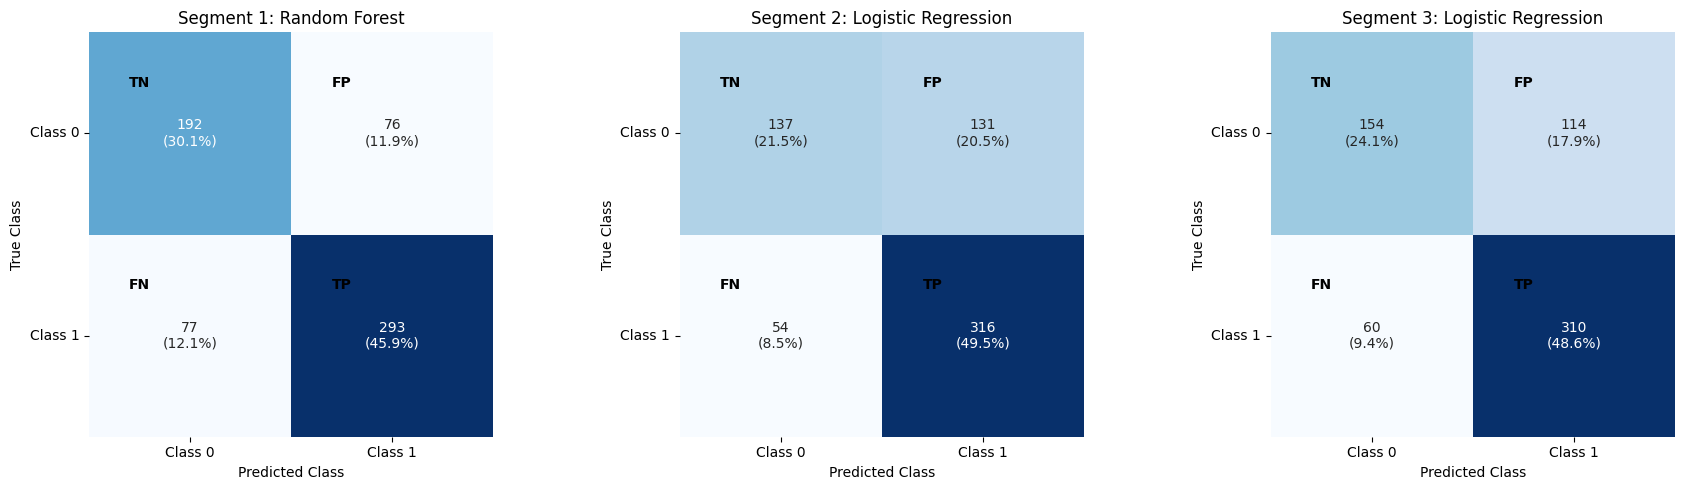

In [60]:
best_model_seg1 = segment1_triple_df_sorted.index[0]
best_model_seg2 = segment2_triple_df_sorted.index[0]
best_model_seg3 = segment3_triple_df_sorted.index[0]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cmap = plt.cm.Blues

# process each segment
for i, (seg_name, model_name, cm_dict) in enumerate([
    ("Segment 1", best_model_seg1, segment1_triple_confusion_matrices),
    ("Segment 2", best_model_seg2, segment2_triple_confusion_matrices),
    ("Segment 3", best_model_seg3, segment3_triple_confusion_matrices)
]):
    cm = cm_dict[model_name]
    # percentages
    cm_sum = np.sum(cm)
    cm_percentages = cm / cm_sum * 100
    
    annot = np.empty_like(cm, dtype=object)
    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            annot[j, k] = f"{cm[j, k]}\n({cm_percentages[j, k]:.1f}%)"
    
    sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, ax=axes[i],
              cbar=False, square=True)
    axes[i].set_title(f"{seg_name}: {model_name}")
    
    # labels
    axes[i].set_xlabel('Predicted Class')
    axes[i].set_ylabel('True Class')
    
    axes[i].set_xticklabels(['Class 0', 'Class 1'])
    axes[i].set_yticklabels(['Class 0', 'Class 1'], rotation=0)
    
    # ticks
    axes[i].text(0.25, 0.25, 'TN', color='black', ha='center', va='center', fontweight='bold')
    axes[i].text(1.25, 0.25, 'FP', color='black', ha='center', va='center', fontweight='bold')
    axes[i].text(0.25, 1.25, 'FN', color='black', ha='center', va='center', fontweight='bold')
    axes[i].text(1.25, 1.25, 'TP', color='black', ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### Comparison

In [61]:
triple_segment_comparison = pd.DataFrame({
    'Segment': ['Triple Segment 1', 'Triple Segment 2', 'Triple Segment 3'],
    'Best Model': [
        segment1_triple_df_sorted.index[0],
        segment2_triple_df_sorted.index[0],
        segment3_triple_df_sorted.index[0]
    ],
    'Best F1 Score': [
        segment1_triple_df_sorted.iloc[0]['Mean F1 Score'],
        segment2_triple_df_sorted.iloc[0]['Mean F1 Score'],
        segment3_triple_df_sorted.iloc[0]['Mean F1 Score']
    ]
})

print("\n=== COMPARISON OF TRIPLE SEGMENTS ===")
print(triple_segment_comparison)


=== COMPARISON OF TRIPLE SEGMENTS ===
            Segment           Best Model  Best F1 Score
0  Triple Segment 1        Random Forest       0.791185
1  Triple Segment 2  Logistic Regression       0.773230
2  Triple Segment 3  Logistic Regression       0.780735


## All-features Three Segments Models

### Data Splitting

In [62]:
all_features = ["total_activity_1", 'mean_act_1', 'std_act_1', 'max_act_1', 'min_act_1', 'median_act_1', 'inactivity_perc_1', 
                "total_activity_2", 'mean_act_2', 'std_act_2', 'max_act_2', 'min_act_2', 'median_act_2', 'inactivity_perc_2', 
                "total_activity_3", 'mean_act_3', 'std_act_3', 'max_act_3', 'min_act_3', 'median_act_3', 'inactivity_perc_3']

X_triple = triple[all_features].dropna()
y_hat = triple.loc[X_triple.index, 'type']

### Evaluation

In [63]:
new_confusion_matrices = {}
new_metrics_results = {}

for name, model in models.items():
    print(f'Evaluating {name}...')
    cv_results = manual_cv(X_triple, y_hat, model, n_splits=10, random_state=42)
    
    new_confusion_matrices[name] = cv_results['confusion_matrix']
    
    new_metrics_results[name] = {
        "Mean F1 Score": cv_results["f1"]["mean"],
        "Std F1 Score": cv_results["f1"]["std"],
        "Mean Accuracy": cv_results["accuracy"]["mean"],
        "Std Accuracy": cv_results["accuracy"]["std"],
        "Mean Precision": cv_results["precision"]["mean"],
        "Std Precision": cv_results["precision"]["std"],
        "Mean Recall": cv_results["recall"]["mean"],
        "Std Recall": cv_results["recall"]["std"]
   }

Evaluating SVM...
Evaluating Random Forest...
Evaluating KNN...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linea

In [64]:
new_df_MR = pd.DataFrame.from_dict(new_metrics_results, orient='columns')
new_df_MR = new_df_MR.T
new_df_MR_sorted = new_df_MR.sort_values(by='Mean F1 Score', ascending=False)
print("Cross-Validation Metrics:")
new_df_MR_sorted

Cross-Validation Metrics:


,Mean F1 Score,Std F1 Score,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall
KNN,0.830244,0.031645,0.796156,0.038149,0.803566,0.033344,0.859459,0.037838
Random Forest,0.827288,0.045017,0.793056,0.052861,0.802012,0.047026,0.856757,0.062863
Gradient Boosting,0.820984,0.046817,0.788467,0.052170,0.804052,0.042950,0.840541,0.065593
Logistic Regression,0.787997,0.035836,0.746057,0.035688,0.763080,0.032843,0.818919,0.070530
SVM,0.786071,0.035621,0.746032,0.034529,0.766842,0.029523,0.810811,0.073521


### Results

In [65]:
new_cm_metrics = {}

for name, cm in new_confusion_matrices.items():
    tn, fp = cm[0,0], cm[0,1]
    fn, tp = cm[1,0], cm[1,1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    new_cm_metrics[name] = {
        "F1 Score": round(f1, 4),
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4)
    }

In [66]:
new_cm_metrics_df = pd.DataFrame.from_dict(new_cm_metrics, orient='index')

In [67]:
for name, cm in new_confusion_matrices.items():
    class_0_samples = cm[0, 0] + cm[0, 1]
    class_1_samples = cm[1, 0] + cm[1, 1]
    total_samples = class_0_samples + class_1_samples
    
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    recall_0 = cm[0, 0] / class_0_samples if class_0_samples > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    
    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall_1 = cm[1, 1] / class_1_samples if class_1_samples > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    weighted_f1 = (class_0_samples/total_samples * f1_0) + (class_1_samples/total_samples * f1_1)
    cm_metrics_df.at[name, "Weighted F1"] = round(weighted_f1, 4)
    
new_metrics_sorted = new_cm_metrics_df.sort_values(by='F1 Score', ascending=False)
print("\nConfusion Matrix Metrics:")
new_metrics_sorted


Confusion Matrix Metrics:


,F1 Score,Accuracy,Precision,Recall
KNN,0.8303,0.7962,0.8030,0.8595
Random Forest,0.8277,0.7931,0.8005,0.8568
Gradient Boosting,0.8217,0.7884,0.8036,0.8405
Logistic Regression,0.7891,0.7461,0.7613,0.8189
SVM,0.7874,0.7461,0.7653,0.8108


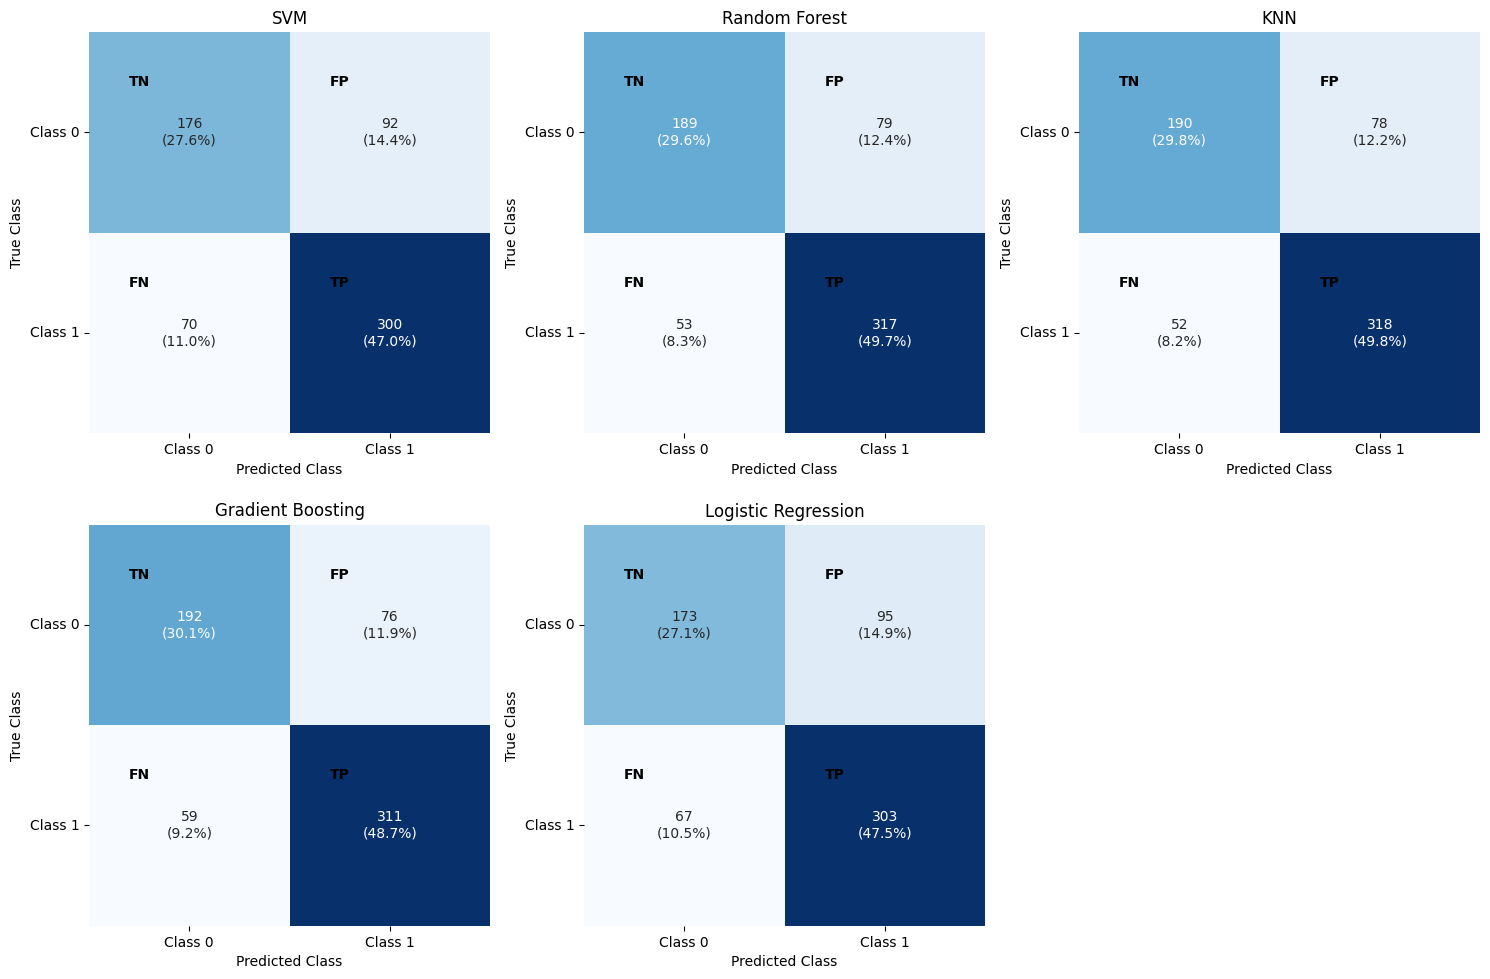

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
cmap = plt.cm.Blues
for i, (name, cm) in enumerate(new_confusion_matrices.items()):
    if i < len(axes):
        # calculate percentages
        cm_sum = np.sum(cm)
        cm_percentages = cm / cm_sum * 100

        annot = np.empty_like(cm, dtype=object)
        for j in range(cm.shape[0]):
            for k in range(cm.shape[1]):
                annot[j, k] = f"{cm[j, k]}\n({cm_percentages[j, k]:.1f}%)"
        sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, ax=axes[i],
                cbar=False, square=True)

        title = f"{name}"
        axes[i].set_title(title)

        # labels for true and predicted classes
        axes[i].set_xlabel('Predicted Class')
        axes[i].set_ylabel('True Class')

        axes[i].set_xticklabels(['Class 0', 'Class 1'])
        axes[i].set_yticklabels(['Class 0', 'Class 1'], rotation=0)

        # set ticks
        axes[i].text(0.25, 0.25, 'TN', color='black', ha='center', va='center', fontweight='bold')
        axes[i].text(1.25, 0.25, 'FP', color='black', ha='center', va='center', fontweight='bold')
        axes[i].text(0.25, 1.25, 'FN', color='black', ha='center', va='center', fontweight='bold')
        axes[i].text(1.25, 1.25, 'TP', color='black', ha='center', va='center', fontweight='bold')
if len(models) < len(axes):
    for i in range(len(models), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

